In [23]:
import os
import sys
import wandb
import argparse
import numpy as np


sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../")))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "")))
import torch
import torchvision.transforms as T
import torchvision

from dataloaders.dataloader_cifar10 import get_cifar10
from dataloaders.dataloader_cifar100 import get_cifar100
from utils.eval_metrics import linear_evaluation
from models.linear_classifer import LinearClassifier
from models.ssl import  SimSiam, Siamese, Encoder, Predictor

import random
from utils.lr_schedulers import LinearWarmupCosineAnnealingLR, SimSiamScheduler
from utils.eval_metrics import Knn_Validation_cont
from copy import deepcopy
from loss import invariance_loss,CovarianceLoss,ErrorCovarianceLoss
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

In [24]:
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = torchvision.transforms.functional.gaussian_blur(x,kernel_size=[3,3],sigma=sigma)#kernel size and sigma are open problems but right now seems ok!
        return x


In [25]:
class Args():
    normalization = 'batch'
    weight_standard = False
    same_lr = True
    pretrain_batch_size = 512
    pretrain_warmup_epochs = 10
    pretrain_warmup_lr = 3e-3
    pretrain_base_lr = 0.03
    pretrain_momentum = 0.9
    pretrain_weight_decay = 5e-4
    min_lr = 0.00
    lambdap = 1.0
    appr = 'barlow_cassle'
    knn_report_freq = 10
    cuda_device = 4
    num_workers = 8
    contrastive_ratio = 0.001
    dataset = 'cifar100'
    class_split = [20,20,20,20,20]
    epochs = [500,500,500,500,500]
    cov_loss_weight = 1.0
    sim_loss_weight = 250.0
    info_loss = 'invariance'
    lambda_norm = 1.0
    subspace_rate = 0.99
    lambda_param = 5e-3
    bsize = 32
    msize = 150
    proj_hidden = 2048
    proj_out = 2048 #infomax 64
    pred_hidden = 512
    pred_out = 2048



In [26]:
args = Args()

In [27]:
if args.dataset == "cifar10":
    get_dataloaders = get_cifar10
    num_classes=10
elif args.dataset == "cifar100":
    get_dataloaders = get_cifar100
    num_classes=100
assert sum(args.class_split) == num_classes
assert len(args.class_split) == len(args.epochs)

In [28]:
num_worker = args.num_workers
#device
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)

cuda:4


In [29]:
#wandb init
wandb.init(project="CSSL",  entity="yavuz-team",
            mode="disabled",
            config=args,
            name= str(args.dataset) + '-algo' + str(args.appr) + "-e" + str(args.epochs) + "-b" 
            + str(args.pretrain_batch_size) + "-lr" + str(args.pretrain_base_lr)+"-CS"+str(args.class_split))

In [30]:
if 'infomax' in args.appr or 'barlow' in args.appr:
    transform = T.Compose([
            T.RandomResizedCrop(size=32, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)]), p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([GaussianBlur()], p=0.5), 
            T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

    transform_prime = T.Compose([
            T.RandomResizedCrop(size=32, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)]), p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([GaussianBlur()], p=0.5), 
            T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

In [31]:
#Dataloaders
print("Creating Dataloaders..")
#Class Based
train_data_loaders, train_data_loaders_knn, test_data_loaders, _, train_data_loaders_linear, train_data_loaders_pure  = get_dataloaders(transform, transform_prime, \
                                    classes=args.class_split, valid_rate = 0.00, batch_size=args.pretrain_batch_size, seed = 0, num_worker= num_worker)
_, train_data_loaders_knn_all, test_data_loaders_all, _, train_data_loaders_linear_all, train_data_loaders_pure_all = get_dataloaders(transform, transform_prime, \
                                        classes=[num_classes], valid_rate = 0.00, batch_size=args.pretrain_batch_size, seed = 0, num_worker= num_worker)


Creating Dataloaders..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [32]:
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)
if 'infomax' in args.appr or 'barlow' in args.appr:
    proj_hidden = args.proj_hidden
    proj_out = args.proj_out
    encoder = Encoder(hidden_dim=proj_hidden, output_dim=proj_out, normalization = args.normalization, weight_standard = args.weight_standard,appr_name =args.appr)
    model = Siamese(encoder)
    model.to(device) #automatically detects from model

cuda:4


In [33]:
#load model here
file_name = 'checkpoints/checkpoint_cifar100-algocassle_barlow-e[500, 500, 500, 500, 500]-b256-lr0.25-CS[20, 20, 20, 20, 20]acc_59.38.pth.tar'
dict = torch.load(file_name)

In [34]:
model.temporal_projector = nn.Sequential(
            nn.Linear(args.proj_out, args.proj_hidden, bias=False),
            nn.BatchNorm1d(args.proj_hidden),
            nn.ReLU(),
            nn.Linear(args.proj_hidden, args.proj_out),
        ).to(device)

In [35]:
model.load_state_dict(dict['state_dict'])

<All keys matched successfully>

In [36]:
def uniform_loss(x, t=2):
    return torch.pdist(x, p=2).pow(2).mul(-t).exp().mean().log()

In [37]:
#collect activations
def collect_activations(model,loader):
    activations = []

    model.eval()
    with torch.no_grad():
        for data_tuple in loader:
            data, target = [t.to(device) for t in data_tuple]
            # Forward prop of the model with single augmented batch
            output = model(data)
            activations.append(output.cpu().numpy())

    activations = np.concatenate(activations)
    return activations

def get_eigenspectrum(activations, max_eigvals=2048):
    """
    Given a (n x n) covariance matrix, compute the 
    eigenspectrum and the coefficient of decay by 
    fitting to the log-spectrum.
    """
    act_shape = activations.shape
    feats = activations.reshape(act_shape[0], -1)

    # batchsize x featdim
    bsz, feat_dim = feats.shape

    centered_ft = feats - feats.mean(axis=0)
    pca = PCA(n_components=min(max_eigvals, bsz, feat_dim), svd_solver='full')
    pca.fit(centered_ft)
    eigenspectrum = pca.explained_variance_ratio_
    return eigenspectrum

In [38]:
activations = collect_activations(model, train_data_loaders_knn_all[0])

In [39]:
uniform_loss(torch.tensor(activations))

tensor(-18.3073)

In [40]:
#load model here
file_name = 'checkpoints/checkpoint_cifar100-algobasic_barlow-e[1000]-b256-lr0.3-CS[100]acc_69.65.pth.tar'
dict = torch.load(file_name, map_location='cpu')

In [41]:
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)
if 'infomax' in args.appr or 'barlow' in args.appr:
    proj_hidden = args.proj_hidden
    proj_out = args.proj_out
    encoder = Encoder(hidden_dim=proj_hidden, output_dim=proj_out, normalization = args.normalization, weight_standard = args.weight_standard,appr_name =args.appr)
    model_offline = Siamese(encoder)
    model_offline.to(device) #automatically detects from model

cuda:4


In [42]:
model_offline.load_state_dict(dict['state_dict'])

<All keys matched successfully>

In [43]:
activations_offline = collect_activations(model_offline, train_data_loaders_knn_all[0])

In [44]:
uniform_loss(torch.tensor(activations_offline))

tensor(-18.3022)

In [59]:
#load model here
file_name = 'checkpoints/checkpoint_cifar100-algoLRD_barlow-e[500, 500, 500, 500, 500]-b256-lr0.1-CS[20, 20, 20, 20, 20]acc_58.13.pth.tar'
dict = torch.load(file_name, map_location='cpu')

In [60]:
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)
if 'infomax' in args.appr or 'barlow' in args.appr:
    proj_hidden = args.proj_hidden
    proj_out = args.proj_out
    encoder = Encoder(hidden_dim=proj_hidden, output_dim=proj_out, normalization = args.normalization, weight_standard = args.weight_standard,appr_name =args.appr)
    model_lrd = Siamese(encoder)
    model_lrd.to(device) #automatically detects from model

cuda:4


In [61]:
activations_lrd = collect_activations(model_lrd, train_data_loaders_knn_all[0])

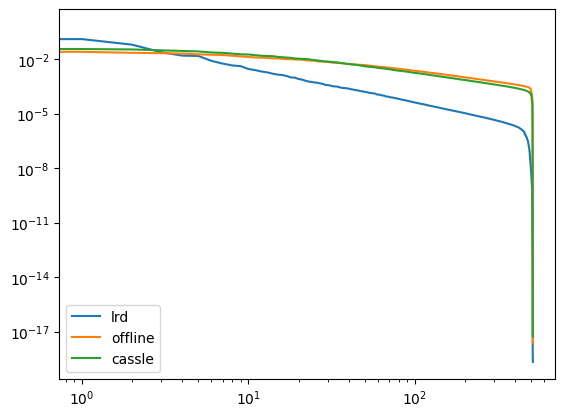

In [62]:
eigenspectrum_lrd = get_eigenspectrum(activations_lrd)
plt.loglog(eigenspectrum_lrd, label='lrd')

eigenspectrum_offline = get_eigenspectrum(activations_offline)
plt.loglog(eigenspectrum_offline,label='offline')

eigenspectrum = get_eigenspectrum(activations)
plt.loglog(eigenspectrum,label='cassle')
plt.legend()

In [16]:
lin_epoch = 200
classifier = LinearClassifier(num_classes = 100).to(device)
lin_optimizer = torch.optim.SGD(classifier.parameters(), 0.1, momentum=0.9) # Infomax: no weight decay, epoch 100, cosine scheduler
lin_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(lin_optimizer, lin_epoch, eta_min=2e-4) #scheduler + values ref: infomax paper
test_loss, test_acc1, test_acc5, classifier = linear_evaluation(model, train_data_loaders_linear_all[0],
                                                                     test_data_loaders_all[0],lin_optimizer, classifier, 
                                                                     lin_scheduler, epochs=lin_epoch, device=device) 

Lin.Train Epoch: [1] Loss: 2.9833 ACC: 36.82: 100%|██████████| 196/196 [00:10<00:00, 18.72it/s]
Lin.Test Epoch: [1] Loss: 2.4023 ACC@1: 45.95% ACC@5: 76.18% : 100%|██████████| 20/20 [00:02<00:00,  6.81it/s]
Lin.Train Epoch: [2] Loss: 2.8101 ACC: 42.30: 100%|██████████| 196/196 [00:11<00:00, 17.76it/s]
Lin.Test Epoch: [2] Loss: 2.2977 ACC@1: 48.74% ACC@5: 77.88% : 100%|██████████| 20/20 [00:02<00:00,  6.82it/s]
Lin.Train Epoch: [3] Loss: 2.7213 ACC: 44.76: 100%|██████████| 196/196 [00:11<00:00, 17.72it/s]
Lin.Test Epoch: [3] Loss: 2.2973 ACC@1: 49.20% ACC@5: 77.95% : 100%|██████████| 20/20 [00:02<00:00,  7.15it/s]
Lin.Train Epoch: [4] Loss: 2.7831 ACC: 44.33: 100%|██████████| 196/196 [00:11<00:00, 16.77it/s]
Lin.Test Epoch: [4] Loss: 2.3700 ACC@1: 49.39% ACC@5: 77.94% : 100%|██████████| 20/20 [00:03<00:00,  6.16it/s]
Lin.Train Epoch: [5] Loss: 2.7106 ACC: 45.39: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]
Lin.Test Epoch: [5] Loss: 2.3429 ACC@1: 49.79% ACC@5: 78.90% : 100%|████████